# Statistical Analysis and Forecasting on Sunspots Time Series

A time series is a sequence of data points that occur in successive order over some period of time. The sunspot dataset consists of montly readings of sunspot activity from 1749 to 2018. Hence, we will first look for some patterns in the sunspot time series. 

## Imports

Firstly, import the packages you will need to execute all the code in this lab. You will use:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) to build your model and prepare data windows
* [Numpy](https://numpy.org/) for numerical processing
* and Matplotlib's [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) library for visualization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Plotting function

In [2]:
def plot_series(x, y, start=0, end=None, figsize=(16, 5),
                title=None, xlabel=None, ylabel=None, 
                legend=None, linestyle='-', color=None, 
                xlim=None, ylim=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      linestyle (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=figsize, dpi=360)
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], linestyle=linestyle, color=color)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], linestyle=linestyle, color=color)
    
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title, fontsize=20)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

You will also place the functions to generate your synthetic data here. For this lab, you will just need trend, seasonality, and noise. Feel free to add others later in case you want a more challenging task.

## Reading in dataset

In [3]:
# Initialize lists
time_stamp = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_stamp.append(int(row[0]))
    sunspots.append(float(row[2]))


In [4]:
# Convert lists to numpy arrays
time = np.array(time_stamp)
series = np.array(sunspots)

### Visualise the dataset

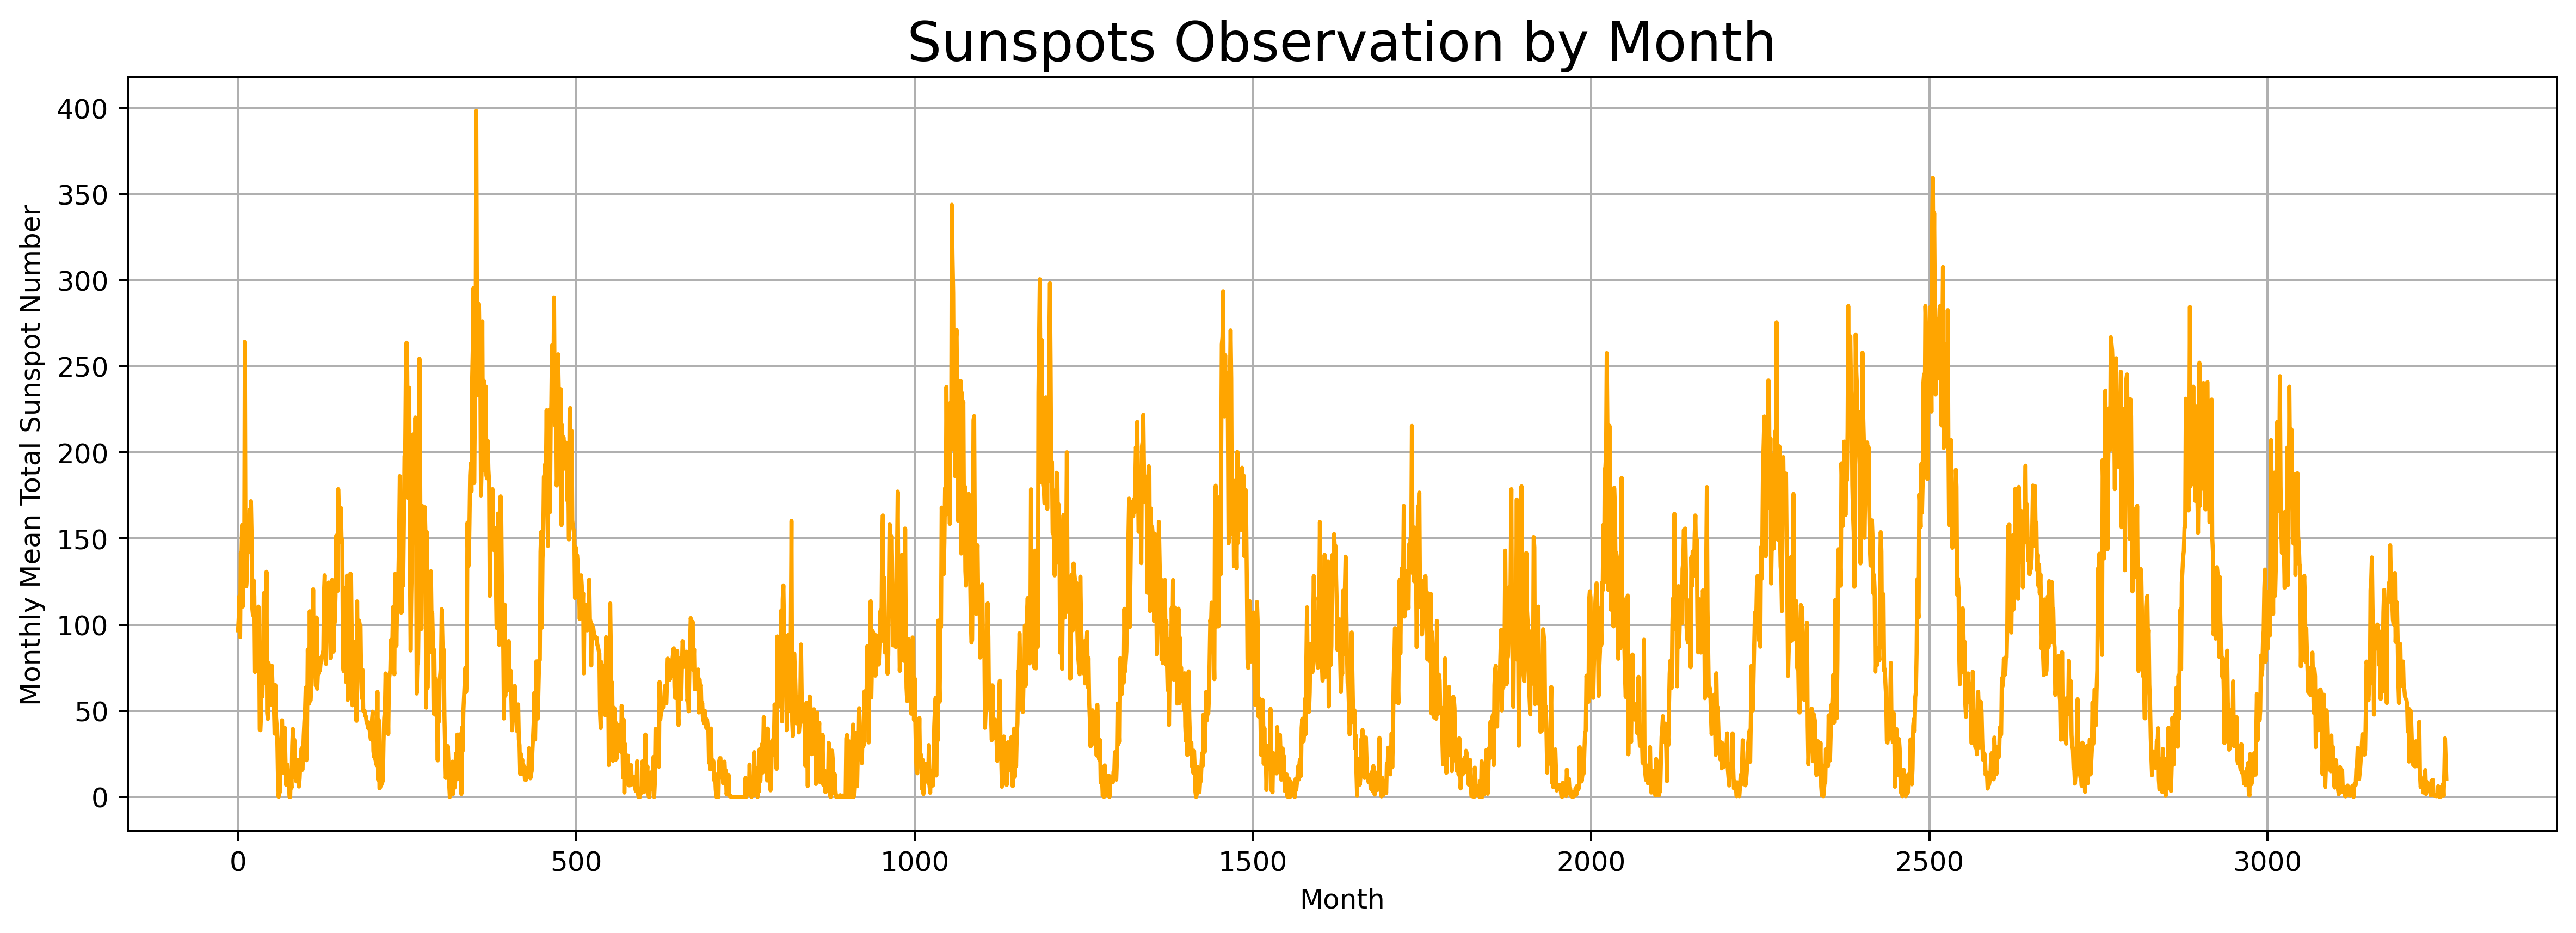

In [5]:

# Preview the data
plot_series(time, series, figsize=(16, 5),
            title='Sunspots Observation by Month', 
            xlabel='Month', 
            ylabel='Monthly Mean Total Sunspot Number', 
            color='orange',
            # xlim=(245, 250)
            )


You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

## Time series analysis using statistical tools and techniques

### Two side view - To emphasize the trend

Since all the values are positive, we visualise the data in two-sided view to emphasize any underlying patterns. 

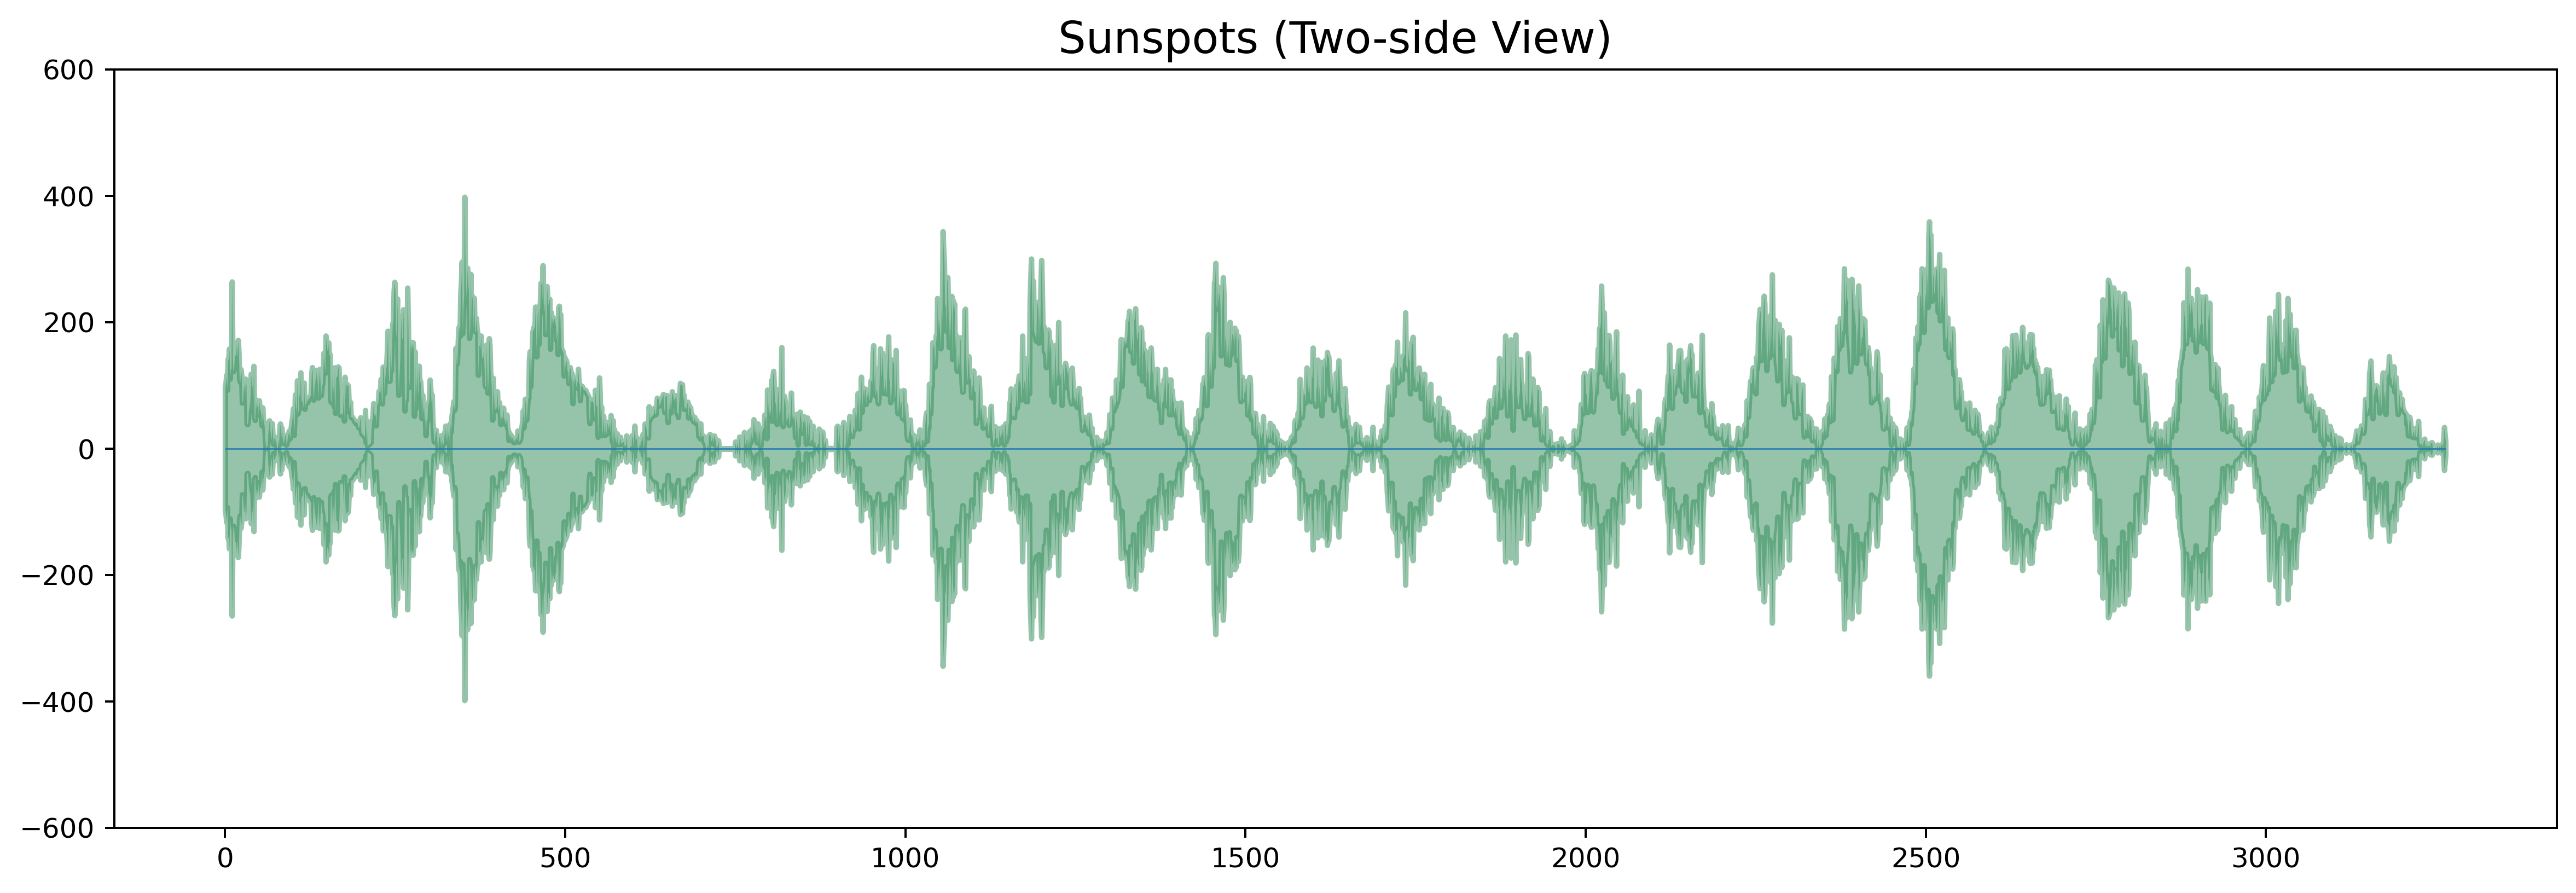

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5), dpi=360)
ax.fill_between(time, y1=series, y2=-series, alpha=0.5, linewidth=2, color='seagreen')
ax.axis(ymin=-600, ymax=600)
ax.set_title('Sunspots (Two-side View)', fontsize=16)
ax.hlines(y=0, xmin=np.min(time), xmax=np.max(time), linewidth=.5)

The values around timestamp 400, 1000 and 2500 are higher than usual. 

Meanwhile, there is no clear growing or decreasing trend in the chart. 

The sunspot time series demonstrates clear cyclical patterns, with amplitudes that rise and fall over varying intervals.

### Decomposition of the Time Series

Decompsition is helpful to reveal underlying patterns by spliting it into 3 components: trend-cycle component, seasonal component, and a remainder component (containing anything else in the time series). There are many techniques to decompose a time series. With 0 values in the dataset, we use *Addtive model* for decomposition. 

Additive combination of the base level, trend, seasonal index and the residual term. 

**Additive time series:**

Value = Base Level + Trend + Seasonality + Error

We  will apply the seasonal_decompose module in the package statsmodels to find out the values of these attributes. 

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd 
from dateutil.parser import parse

seasonal period = 12 for monthly data

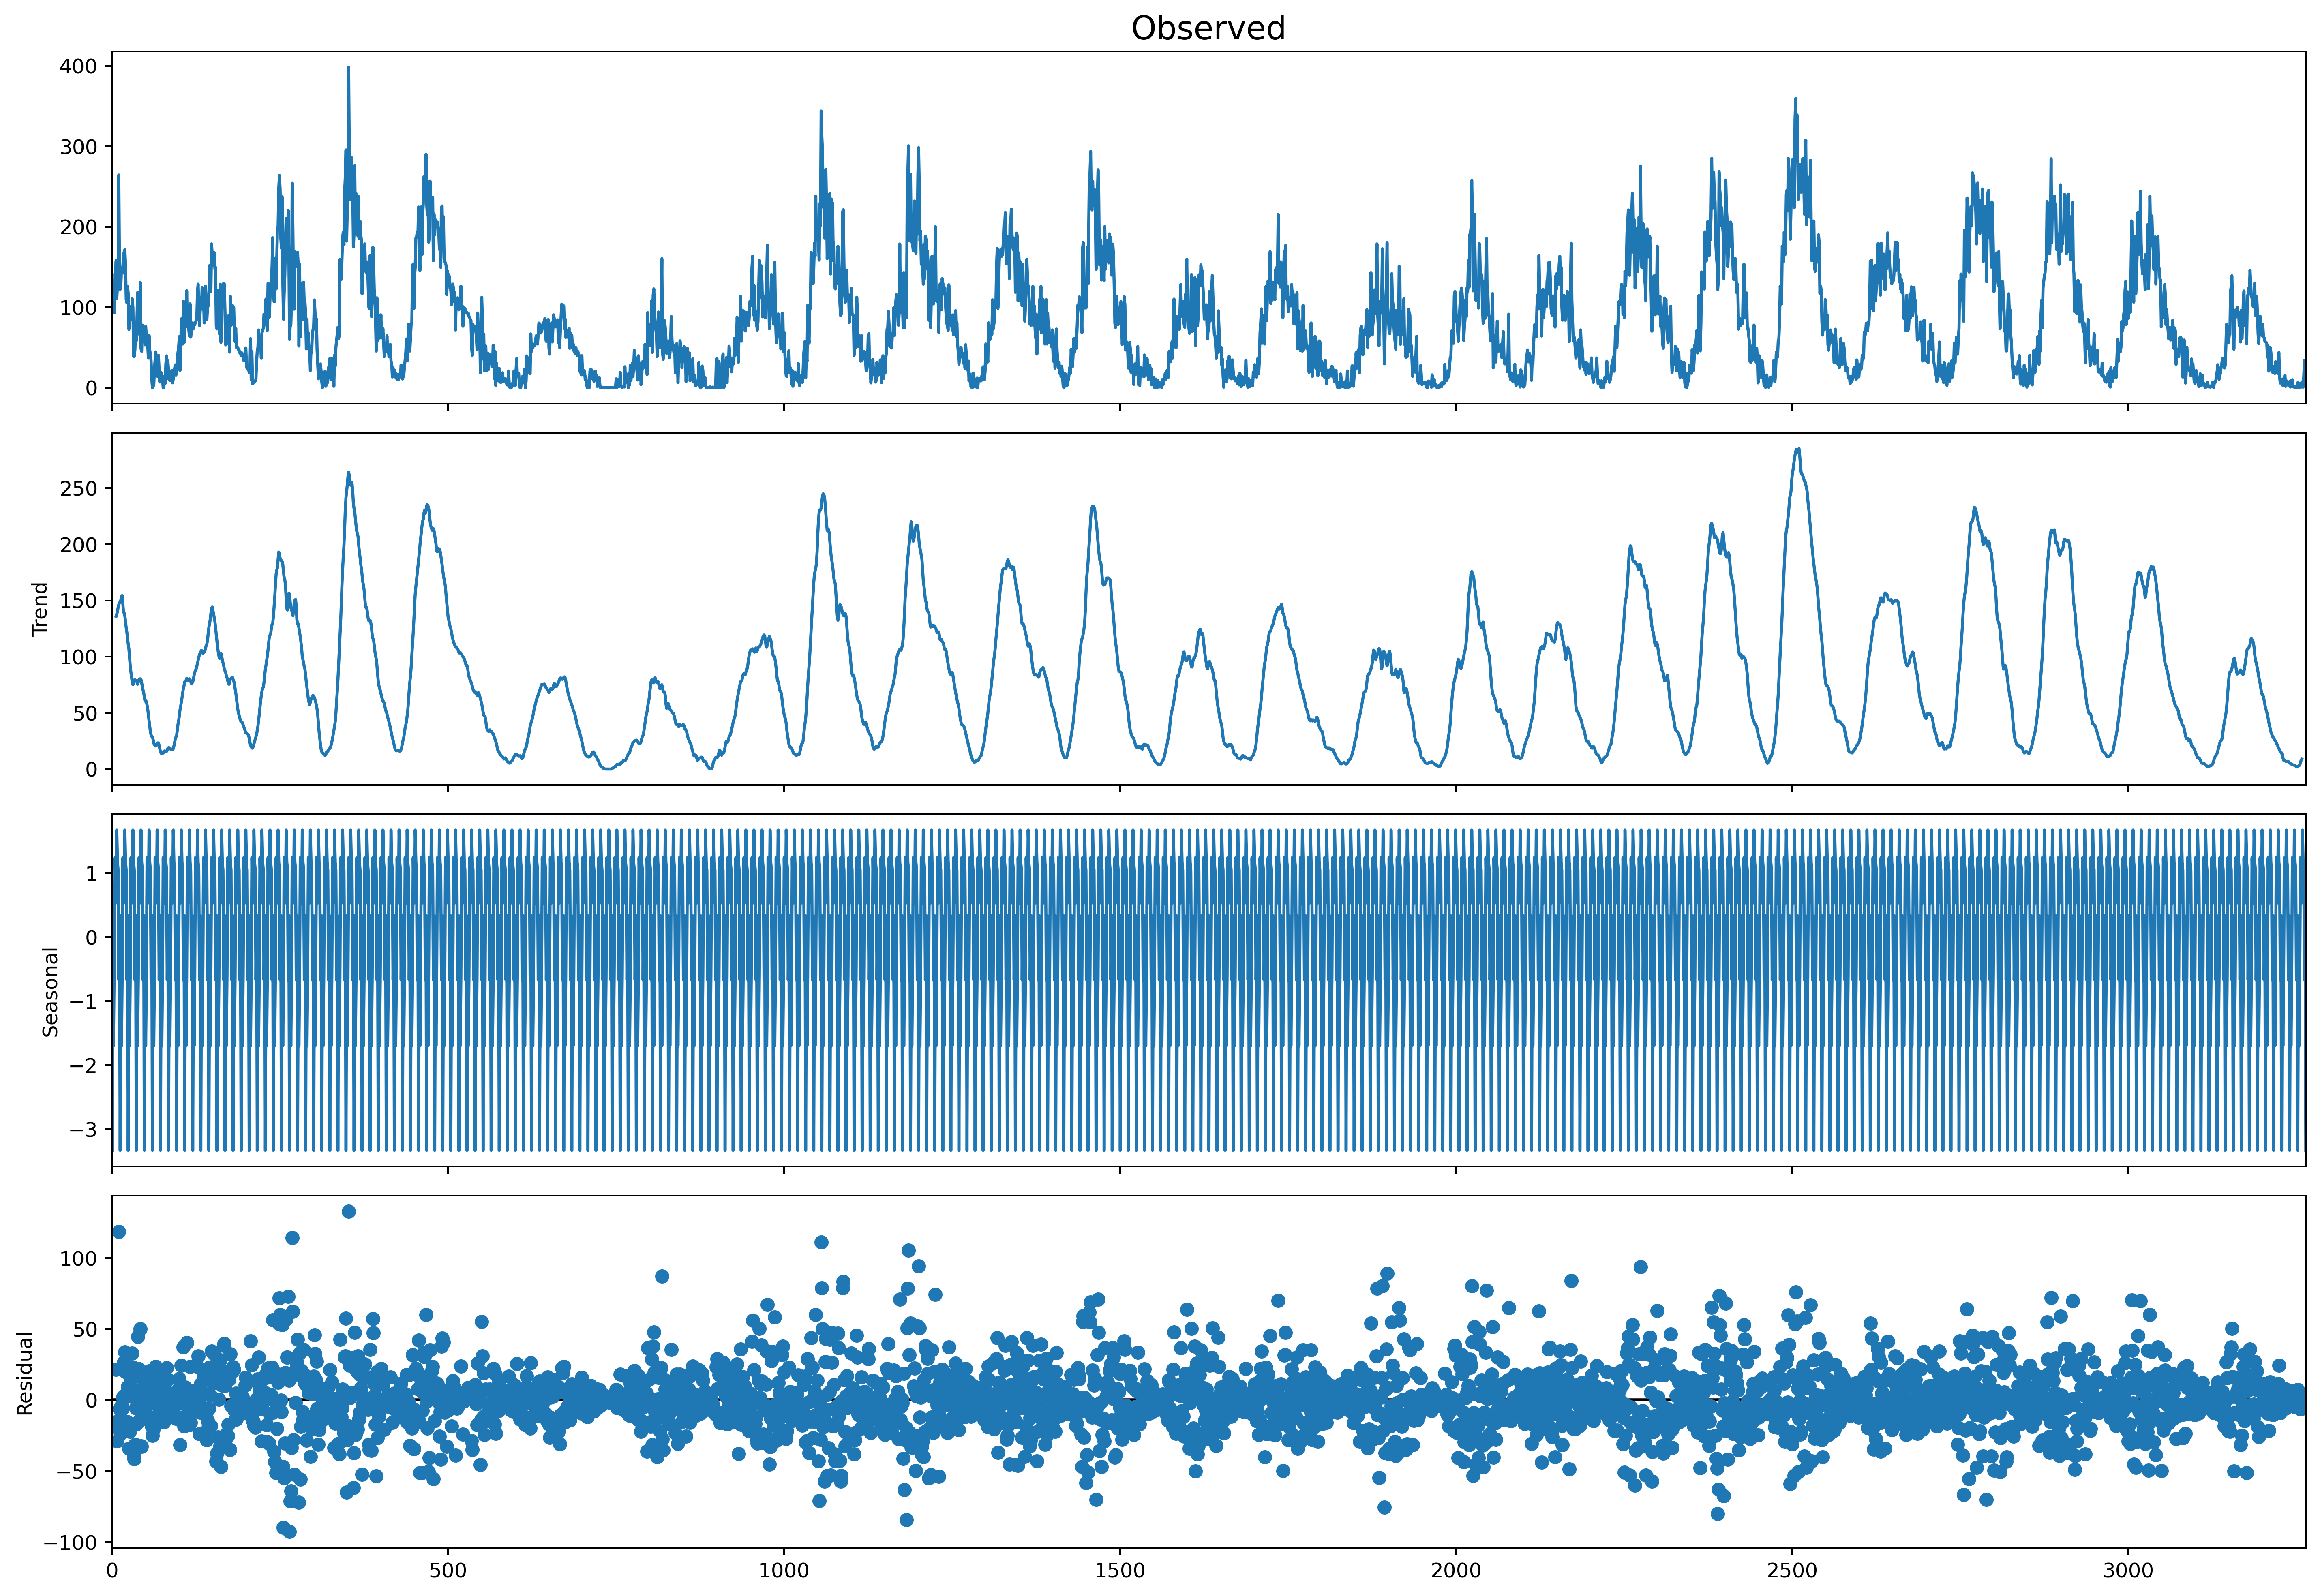

In [13]:
# Multiplicative Decomposition
# multi_decomp = sd(series, model='multiplicative', period=30)

# Additive Decomposition
add_decomp = sd(series,model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12), 'figure.dpi': 360, 'axes.titlesize': 16})
add_decomp.plot()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# fig_decomp = add_decomp.plot()
# plt.show()

### Stationary, Non-stationary Time Series and Conversion

#### Test for stationarity

Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. 

Then, we collect evidence to support or reject the null hypothesis. 

So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

In [16]:
from statsmodels.tsa.stattools import adfuller

stat_res = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {stat_res[0]:.2f}')
print(f'n_lags: {stat_res[1]:.2e}')
print(f'p-value: {stat_res[1]:.2e}')
for key, value in stat_res[4].items():
    print('Critial Values:')
    print(f'   {key}, {value:.3f}') 

print(f'\nThe p-value is less than 0.05. Thus, the series is stationary.')

ADF Statistic: -10.50
n_lags: 1.11e-18
p-value: 1.11e-18
Critial Values:
   1%, -3.432
Critial Values:
   5%, -2.862
Critial Values:
   10%, -2.567

The p-value is less than 0.05. Thus, the series is stationary.


# Basic Forecasting Techniques

**Split the Dataset**

Next up, split the data above into training and validation sets. 

In [19]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Naive Forecast

As a baseline, we do a naive forecast where we assume that the next value will be the same as the previous time step. We will slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In [20]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_stamp = 100

# Print values
print(f'ground truth at time step {time_stamp}: {x_valid[time_stamp]}')
print(f'prediction at time step {time_stamp + 1}: {naive_forecast[time_stamp + 1]}')


ground truth at time step 100: 19.5
prediction at time step 101: 19.5


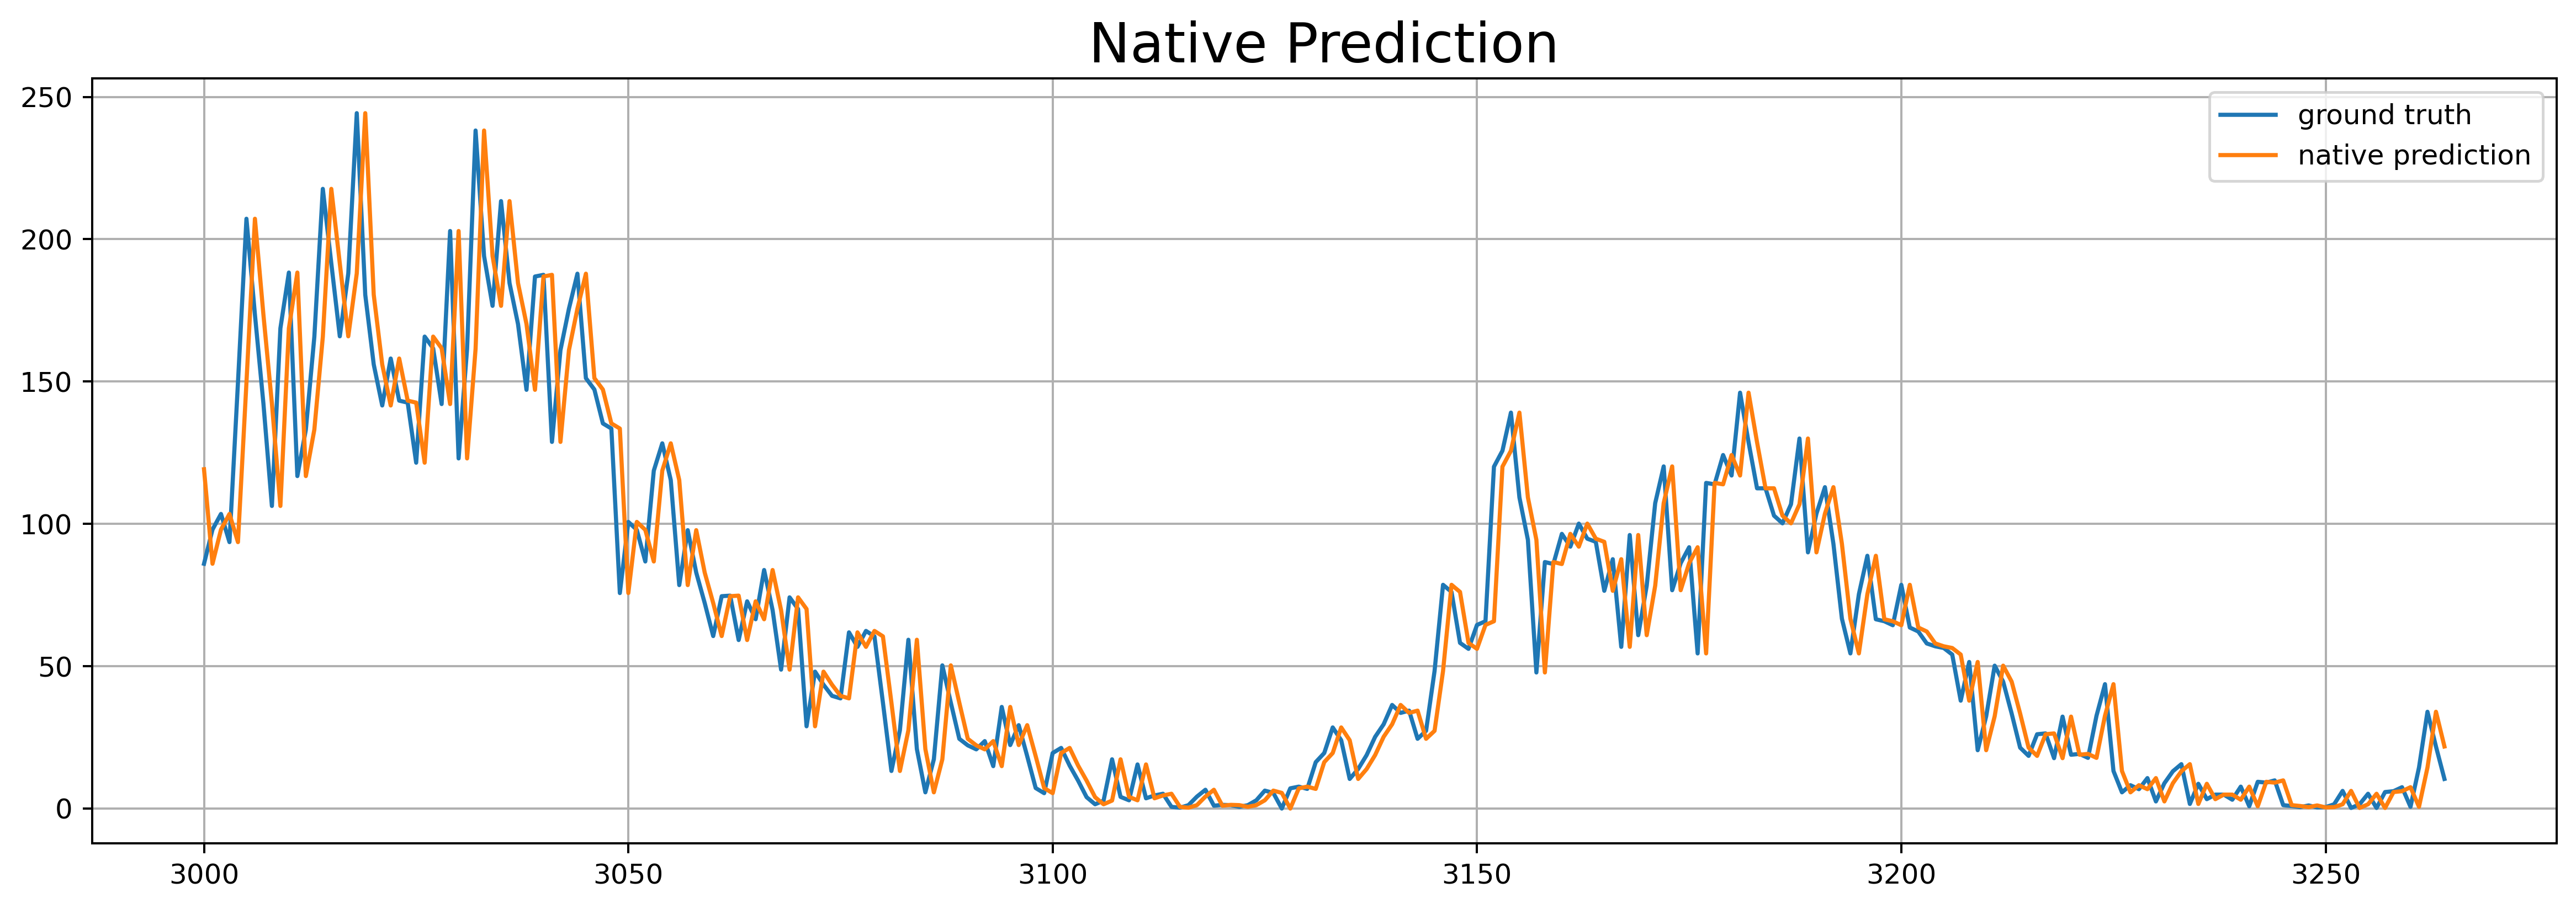

In [21]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast), title='Native Prediction', legend=['ground truth', 'native prediction'])

### Computing Metrics

Now you will compute the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) and the [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAE) between the forecasts and the predictions in the validation period.

In [22]:
print(tf.keras.metrics.mse(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mae(x_valid, naive_forecast).numpy())

469.3581132075472
14.838490566037738


The values above will be your baseline and you will see if you can use other methods to do better than naive forecasting.

## Moving Average

One technique we used is to do a moving average. 

This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire `series`. It takes a `window_size` argument to indicate the number of time steps to consider when computing the mean.

In [24]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

You will use this function to generate the forecast with a window size of `30`.

### Generate the moving average forecast

Num of timesteps in moving_avg: 3235
Num of timesteps in series: 265


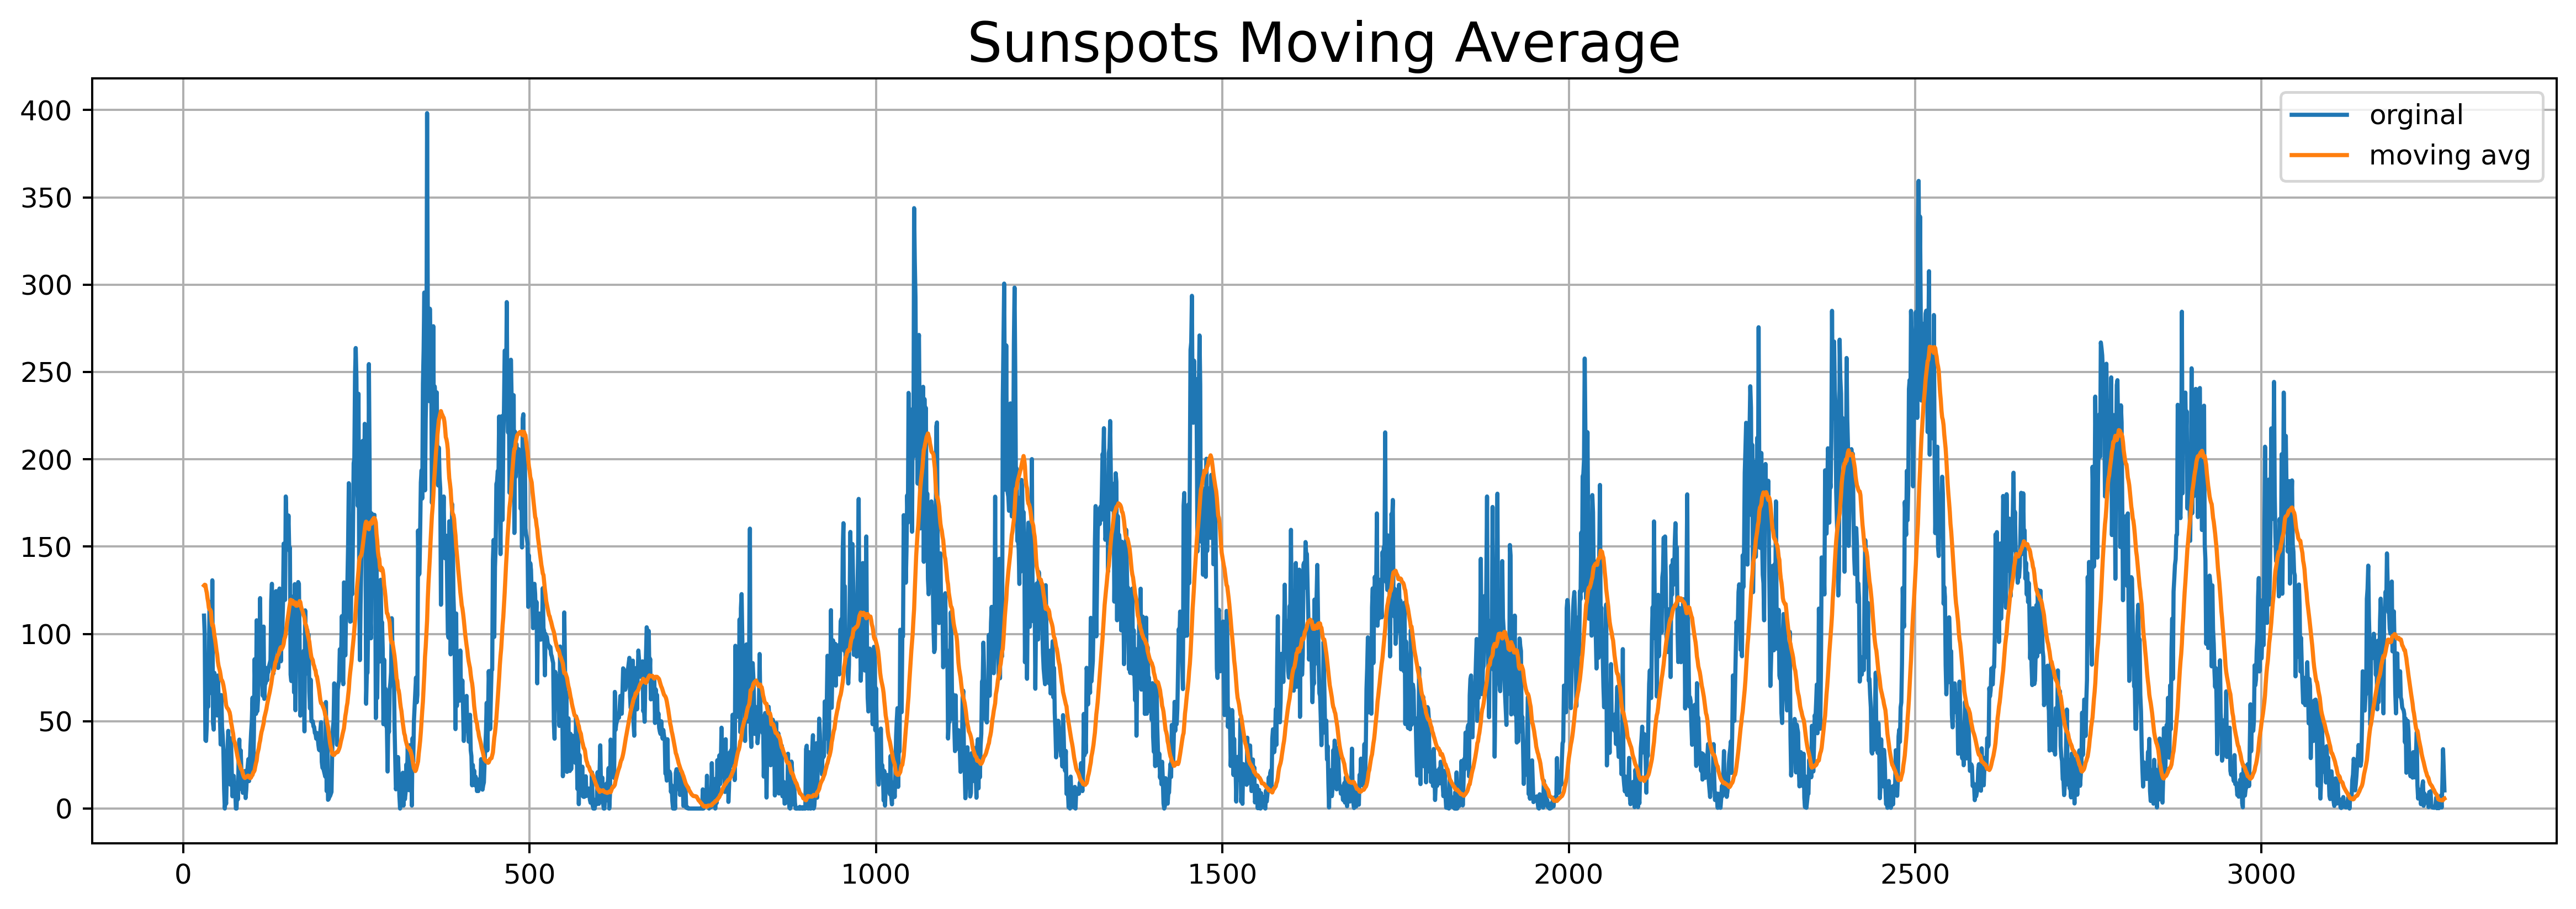

In [28]:
# Set time window
window_size = 30

# Include window_size data points before split time so moving average is same length as original data
moving_avg = moving_average_forecast(series, window_size)
print(f'Num of timesteps in moving_avg: {len(moving_avg)}')
print(f'Num of timesteps in series: {len(x_valid)}')
# Plot the results
plot_series(time[window_size:], (series[window_size:], moving_avg), title='Sunspots Moving Average', legend=['orginal', 'moving avg'])

Num of timesteps in moving_avg: 265
Num of timesteps in series: 265


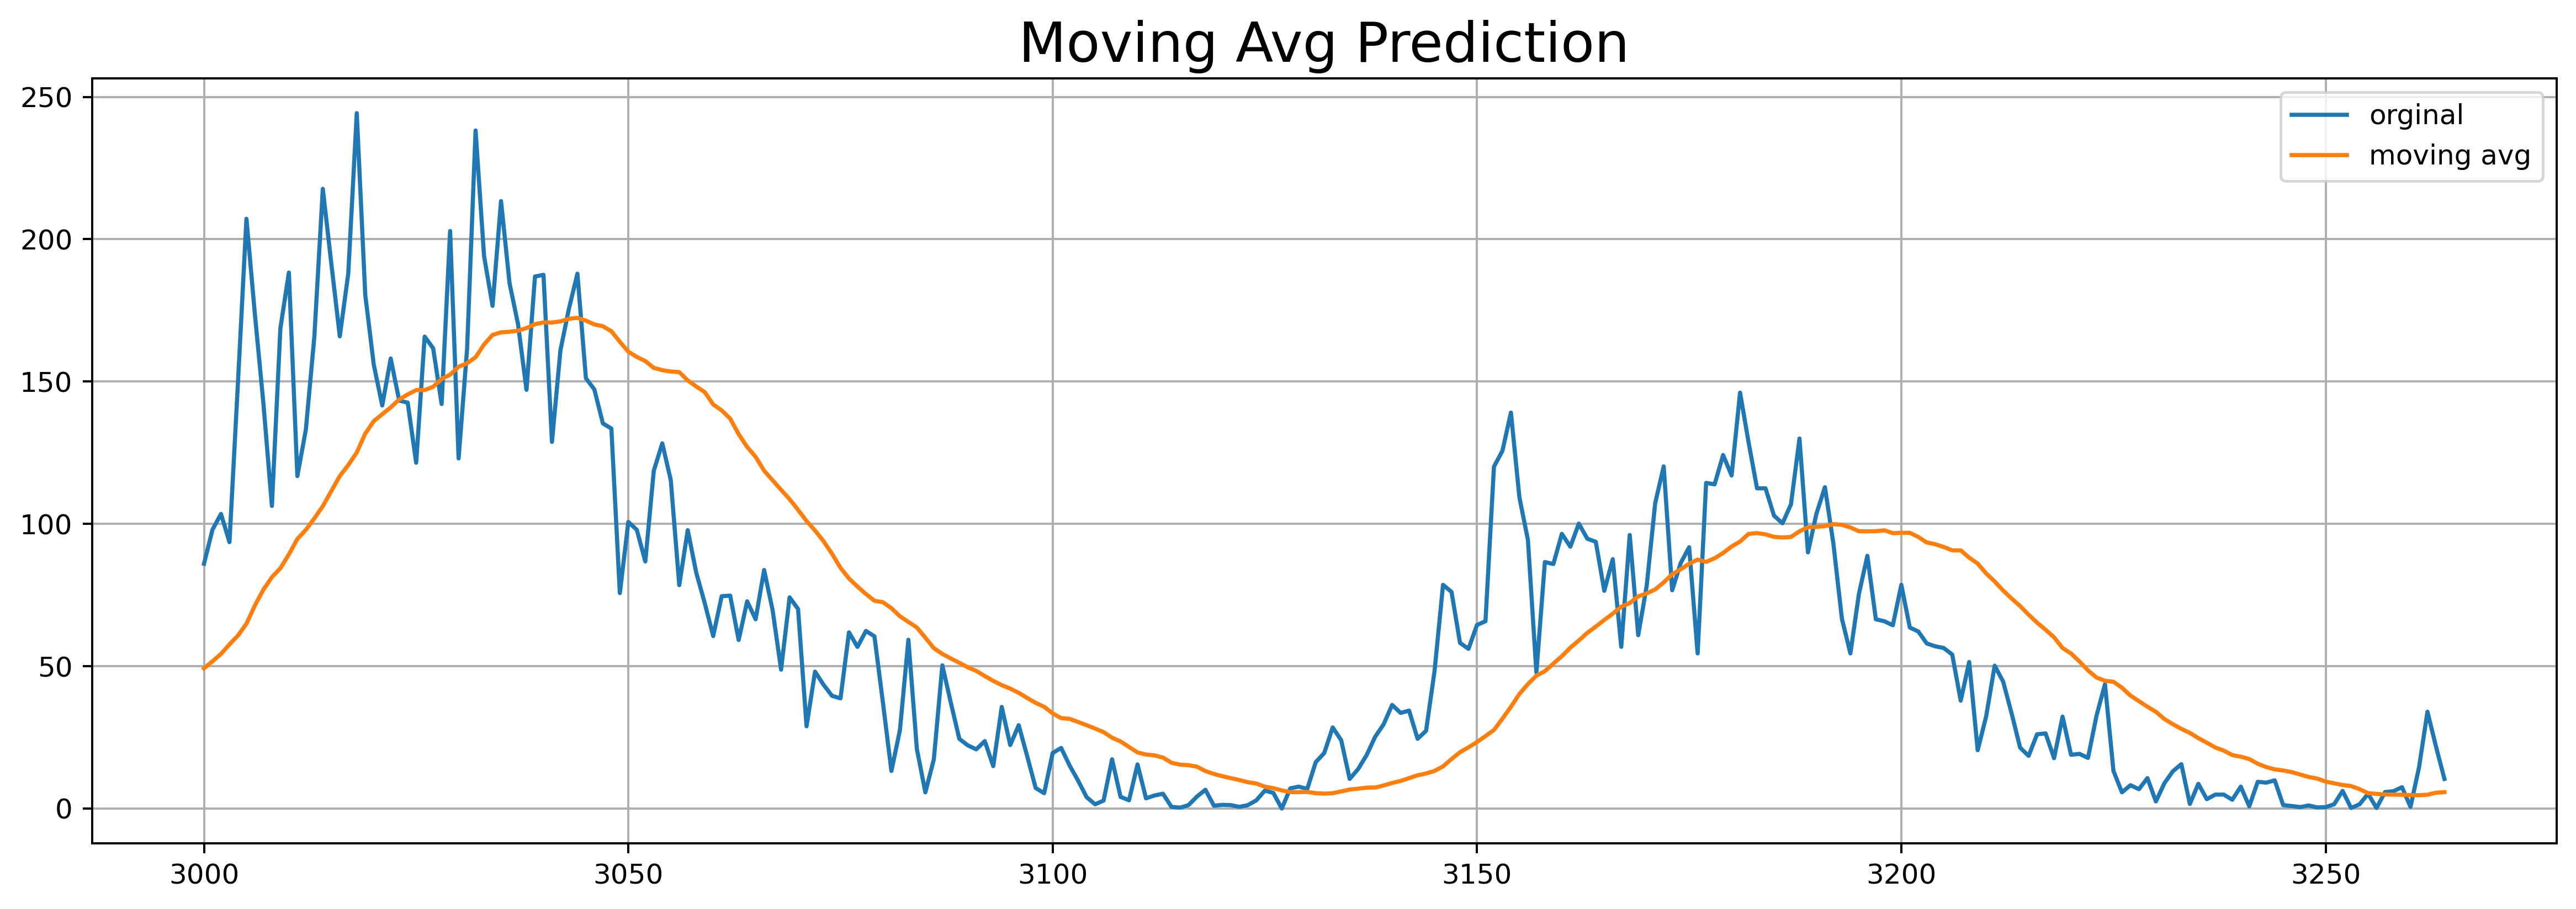

In [29]:
# Set time window
window_size = 30

# Include window_size data points before split time so moving average is same length as original data
moving_avg_forcast = moving_average_forecast(series, window_size)[split_time - window_size:] 
print(f'Num of timesteps in moving_avg: {len(moving_avg_forcast)}')
print(f'Num of timesteps in series: {len(x_valid)}')
# Plot the results
plot_series(time_valid, (x_valid, moving_avg_forcast), title='Moving Avg Prediction', legend=['orginal', 'moving avg'])

In [30]:
# Compute the metrics
print(f'MSE = {tf.keras.metrics.mse(x_valid, moving_avg_forcast).numpy()}')
print(f'MAE = {tf.keras.metrics.mae(x_valid, moving_avg_forcast).numpy()}')

MSE = 1464.3184958490563
MAE = 29.66387421383648


That's worse than the naive forecast! The moving average does not anticipate trend or seasonality. In particular, those huge spikes in the original series causes big deviations as shown in the plot above. You will try to remove these characteristics of the dataset with time differencing and see if you get better results.

## Differencing

Since the cyclic period is 11 years (132 months), we can subtract the value at time *t* – 132 from the value at time *t*. That is done with the code below. 

In addition, we will need to align the result with the `time` array. Since we can only do time differencing for `t >= 132`, we will need to truncate the first 132 time steps of the `time` array.

We can plot the result to visualize the values.

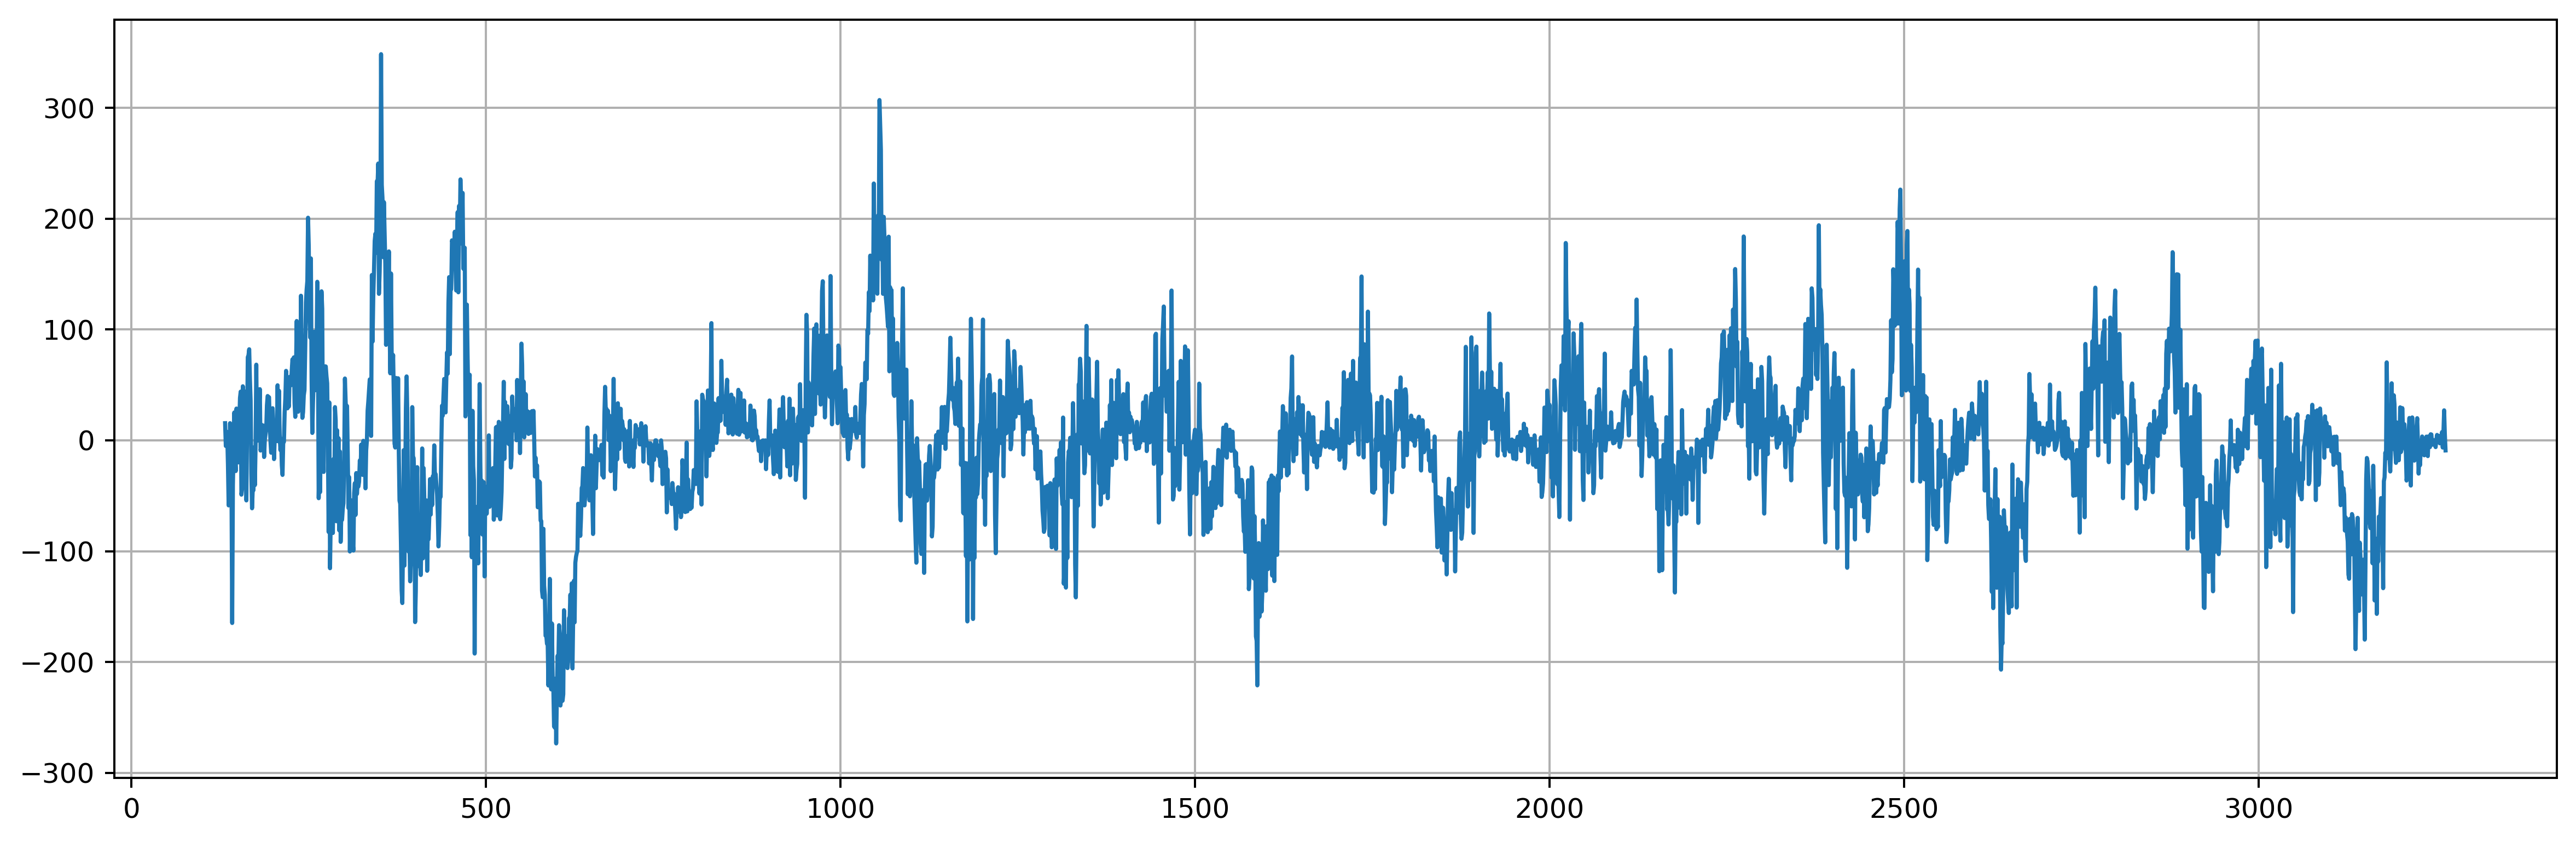

In [37]:
# Set seasonal peirod
season = 132

# Subtract the values at t-132 from original series
diff_series = (series[season:] - series[:-season])

# Truncate the first 132 time steps
diff_time = time[season:]

# Plot the results
plot_series(diff_time, diff_series)

Great! The trend and seasonality seem to be gone so now you can retry using the moving average. `diff_series` is the ground truth while `diff_moving_avg` is the prediction array. You will slice these accordingly to correspond to the validation set time steps before comparing.

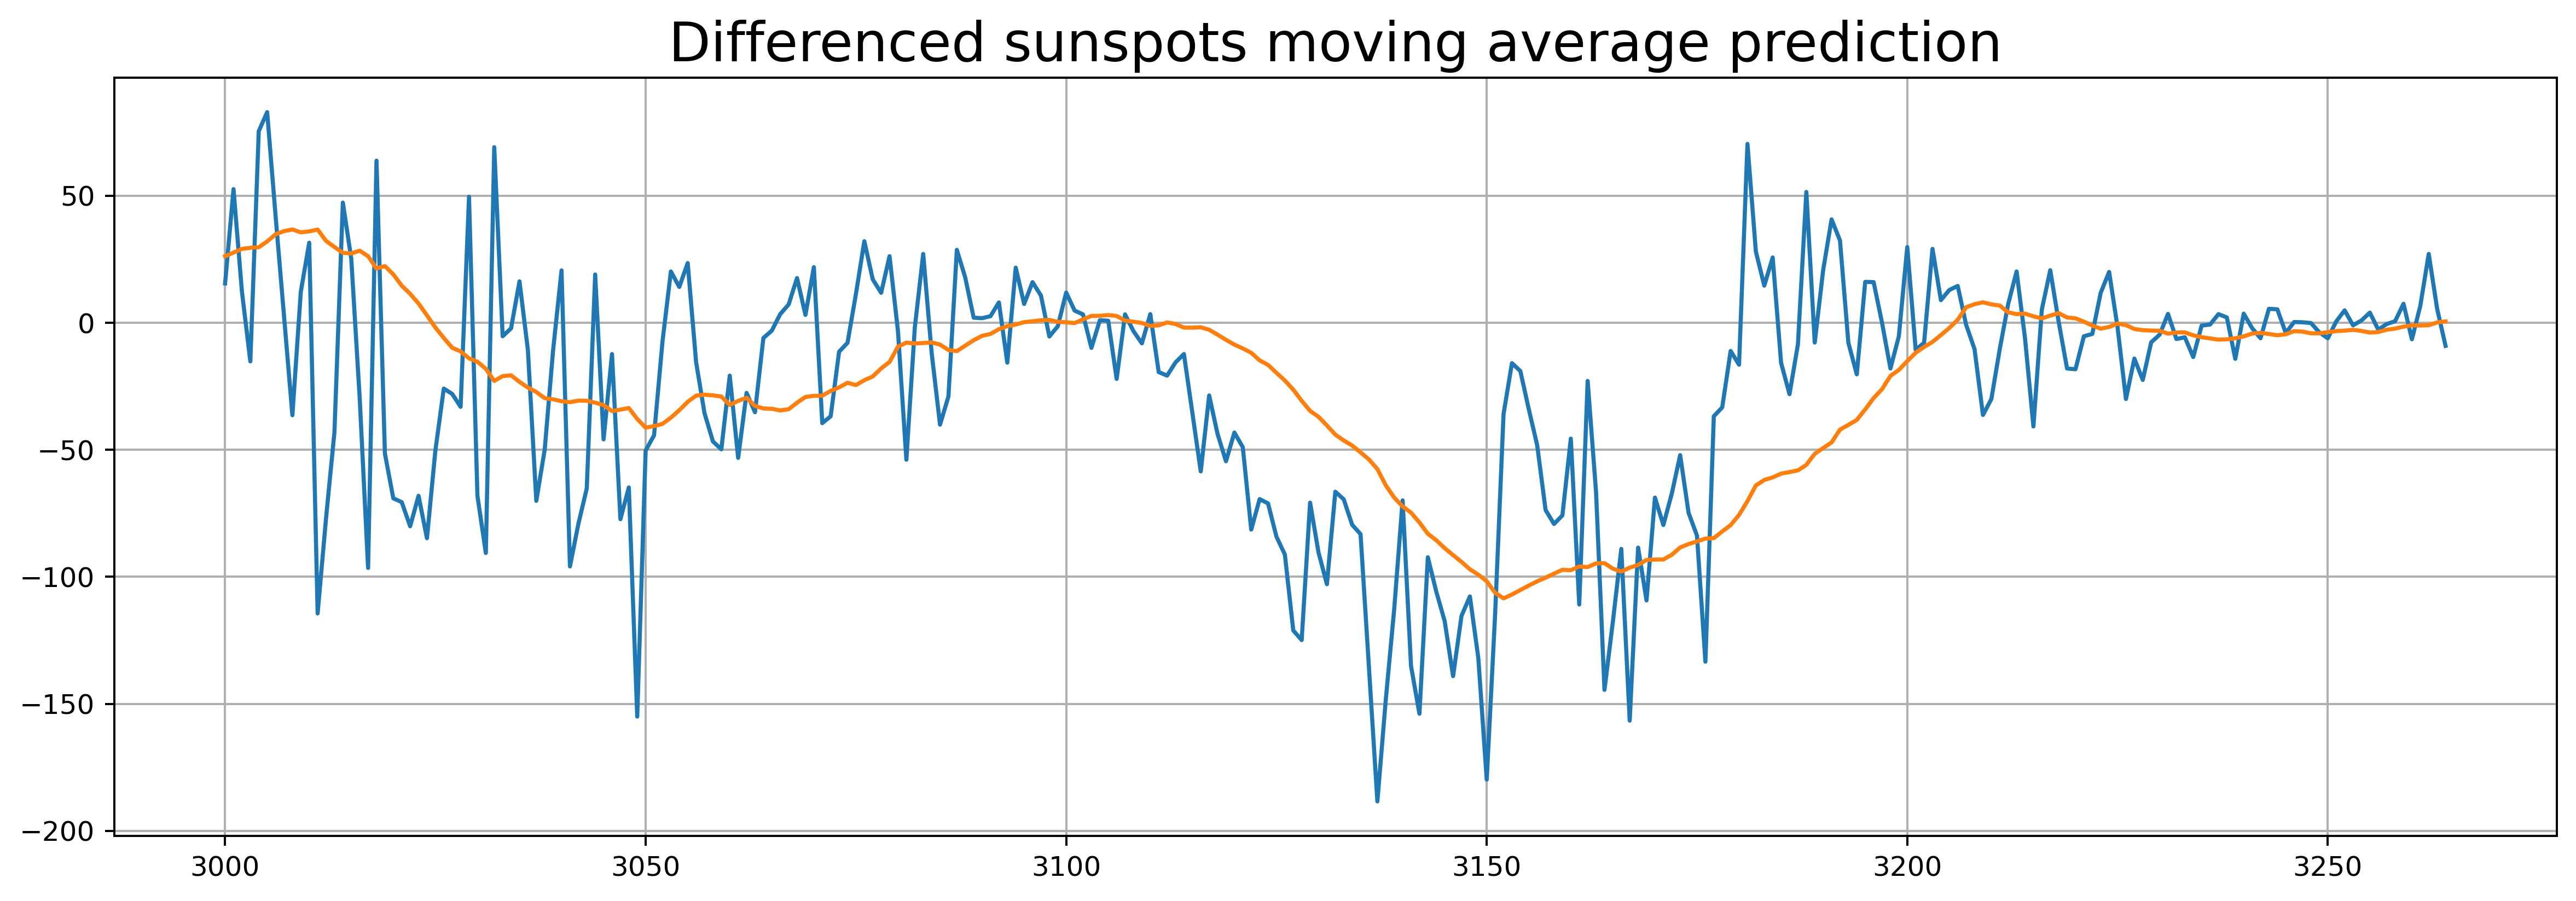

In [38]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, window_size)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - season - window_size:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - season:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg), title='Differenced sunspots moving average prediction')

Now you will bring bring back the trend and seasonality by adding the past values from `t – 365`:

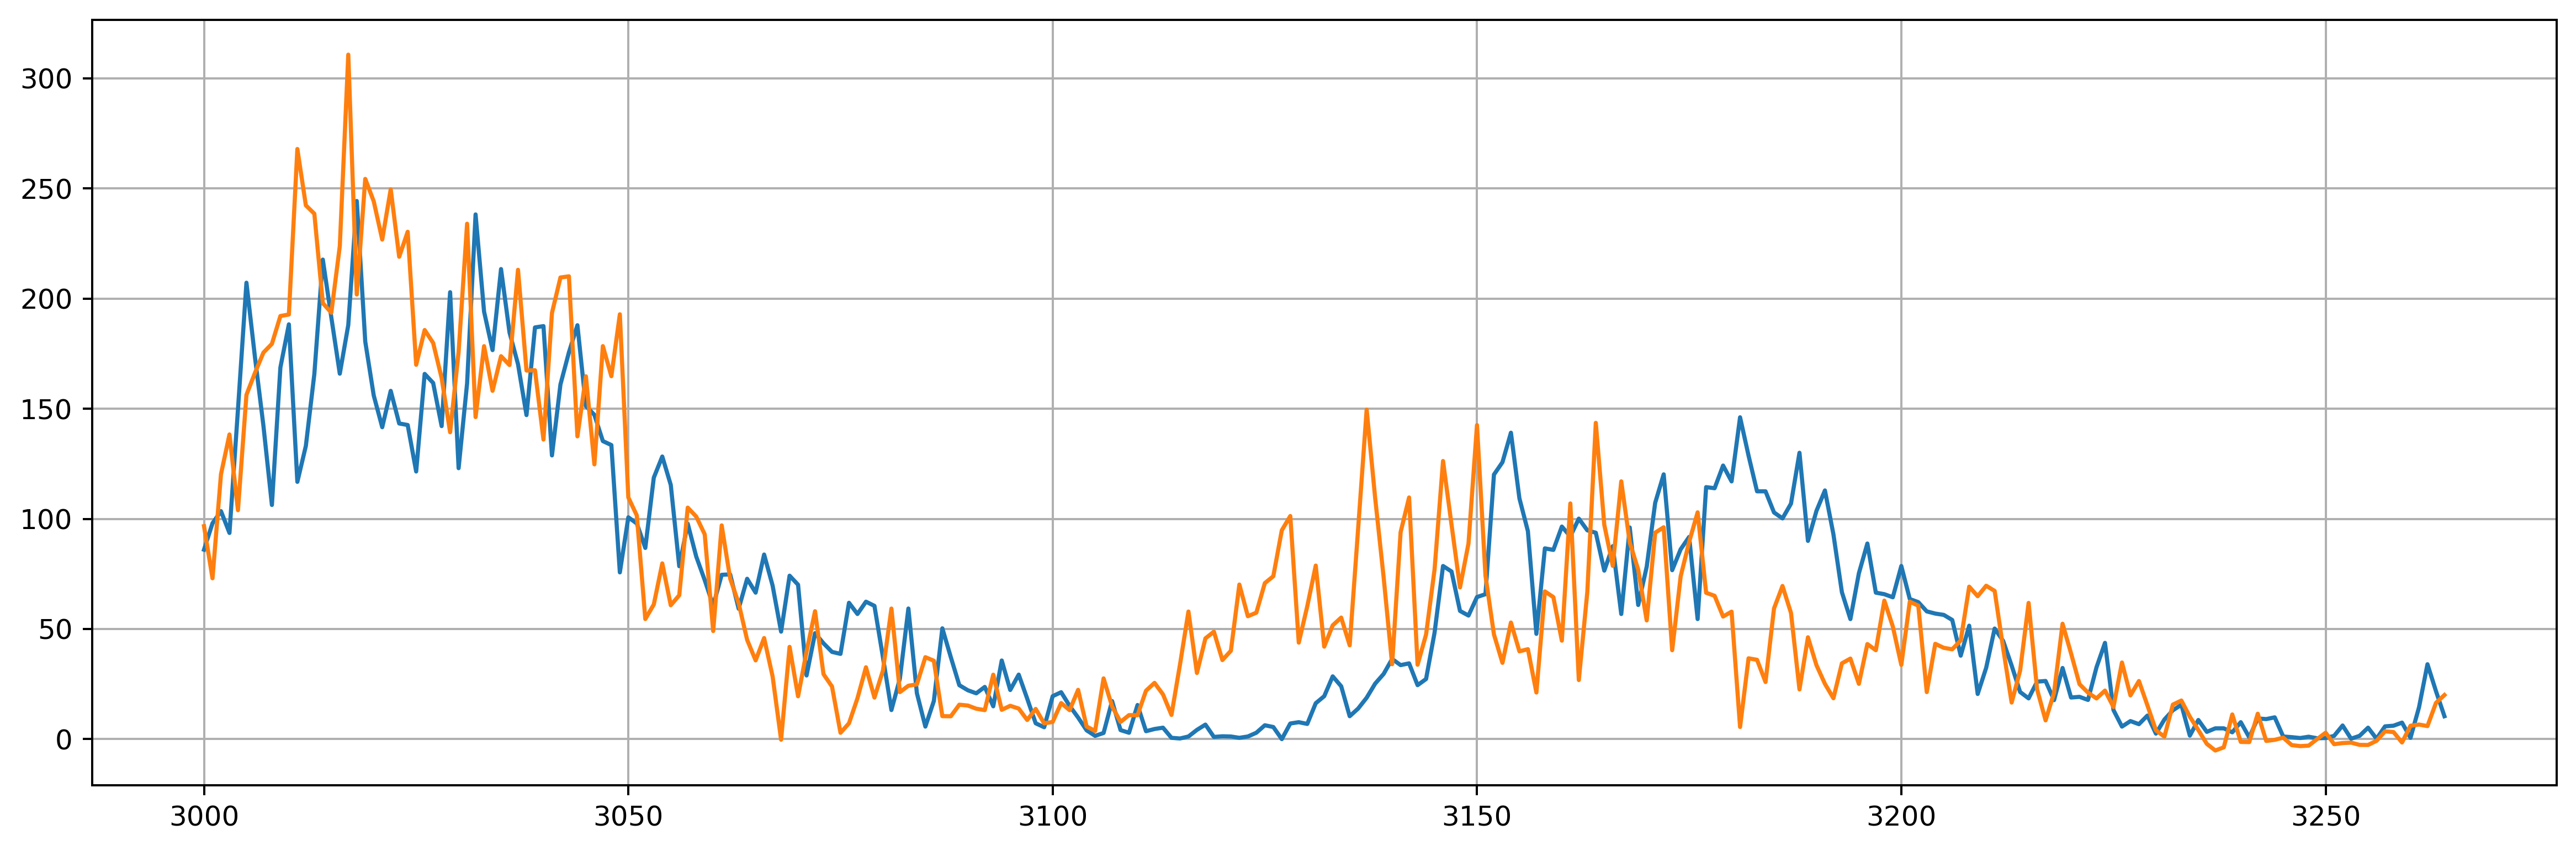

In [39]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - season:-season] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [40]:
print(f'MSE = {tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_past).numpy()}')
print(f'MAE = {tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_past).numpy()}')

MSE = 1878.296608721174
MAE = 31.960779874213838


It is a bit worse than simple moving average forecast. And the forecasts look a bit too random because we're adding past values which are already noisy. Remember that the time differenced signal is also noisy so adding these raw past values can compound this problem. To remedy that, we can use a moving averaging on past values to smooth out some of this noise.

## Smoothing

You can use the same `moving_average_forecast()` function to smooth out past values before adding them back to the time differenced moving average. There are two ways to do this:

* Trailing windows - This refers to getting the mean of past values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=6`**.

* Centered windows - This refers to getting the mean of past *and future* values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=3`**.

The code below will use the centered windows approach and you will notice it in the slicing of the `series` array. It is shifted by `370` steps and the window size is `11`. To get the smooth data point at `t=1000` (i.e. start of the validation set), it will average the measurements at `t=995` to `t=1005`.

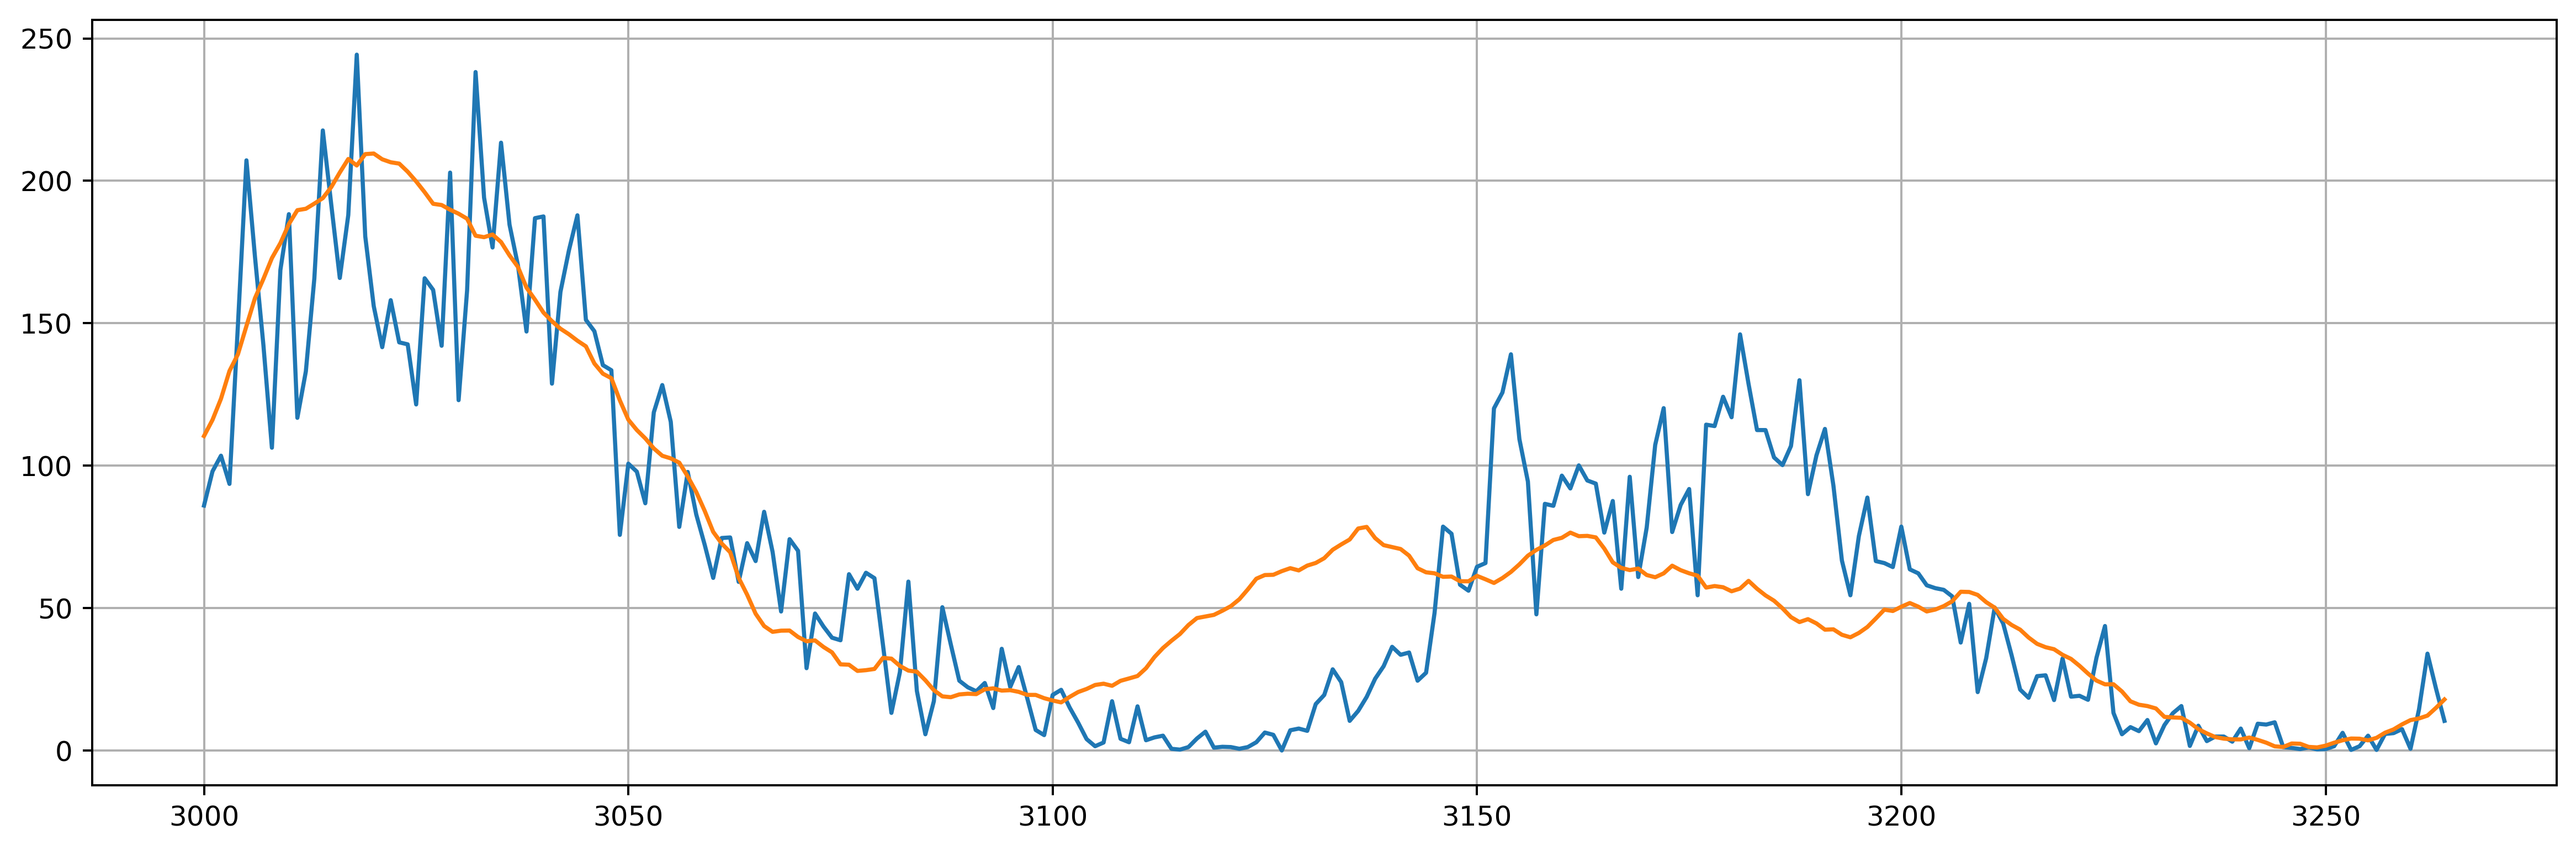

In [41]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - season - int(window_size / 2):-season + int(window_size / 2)], window_size) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

The metrics will show a slight improvement over the previous output.

In [42]:
 # Compute the metrics
print(f'MSE = {tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_smooth_past).numpy()}')
print(f'MAE = {tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_smooth_past).numpy()}')

MSE = 1026.198675220126
MAE = 24.167194968553456


## Wrap up

This concludes a short exploration of statistical methods for time series forecasting.